# Recap
We started by learning about permutation importance and partial dependence plots for an overview of what the model has learned. 

We then learned about SHAP values to break down the components of individual predictions.

Now we'll expand on SHAP values, seeing how aggregating many SHAP values can give more detailed alternatives to permutation importance and partial dependence plots.

# SHAP Values Review

Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).

For example, consider an ultra-simple model:
    $$y = 4 * x1 + 2 * x2$$

If $x1$ takes the value 2, instead of a baseline value of 0, then our SHAP value for $x1$ would be 8 (from 4 times 2).

These are harder to calculate with the sophisticated models we use in practice. But through some algorithmic cleverness, Shap values allow us to decompose any prediction into the sum of effects of each feature value, yielding a graph like this:

![Imgur](https://i.imgur.com/JVD2U7k.png)

[Link to larger view](https://i.imgur.com/JVD2U7k.png)*

In addition to this nice breakdown for each prediction, the [Shap library](https://github.com/slundberg/shap) offers great visualizations of groups of Shap values. We will focus on two of these visualizations. These visualizations have conceptual similarities to permutation importance and partial dependence plots. So multiple threads from the previous exercises will come together here.

# Summary Plots

[Permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has
- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. We'll walk through an example plot for the soccer data:

![Imgur](https://i.imgur.com/Ew9X3su.png)

This plot is made of many dots. Each dot has three characteristics:
- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, the point in the upper left was for a team that scored few goals, reducing the prediction by 0.25.

Some things you should be able to easily pick out:
- The model ignored the `Red` and `Yellow & Red` features. 
- Usually `Yellow Card` doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.
- High values of Goal scored caused higher predictions, and low values caused low predictions

If you look for long enough, there's a lot of information in this graph. You'll face some questions to test how you read them in the exercise.

# Summary Plots in Code

You have already seen the code to load the soccer/football data:

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('data/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]

X['Ball Possession %'] = np.log(X['Ball Possession %'])
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

/tmp/ipykernel_141438/2984425590.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Ball Possession %'] = np.log(X['Ball Possession %'])


We get the SHAP values for all validation data with the following code. It is short enough that we explain it in the comments.

In [4]:
train_X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
88,0,3.988984,10,3,4,3,5,1,8,2,86,557,83,11,1,0,0,0
74,0,3.970292,14,2,7,5,8,3,13,1,86,555,105,13,4,0,0,0
120,1,3.688879,19,5,8,6,4,1,17,3,86,342,102,6,2,0,0,0
45,3,3.737670,15,5,6,4,2,3,18,3,80,372,104,23,4,0,0,0
77,2,4.189655,8,4,3,1,5,2,20,2,84,565,101,15,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,1,3.891820,4,1,2,1,1,0,16,4,85,390,111,19,3,0,0,0
72,0,3.637586,5,1,2,2,4,1,11,4,72,305,106,10,1,0,0,0
12,0,3.951244,18,6,7,5,3,5,21,2,85,394,104,10,1,0,0,0
107,2,3.784190,11,4,4,3,6,1,14,5,83,453,109,9,1,0,0,0


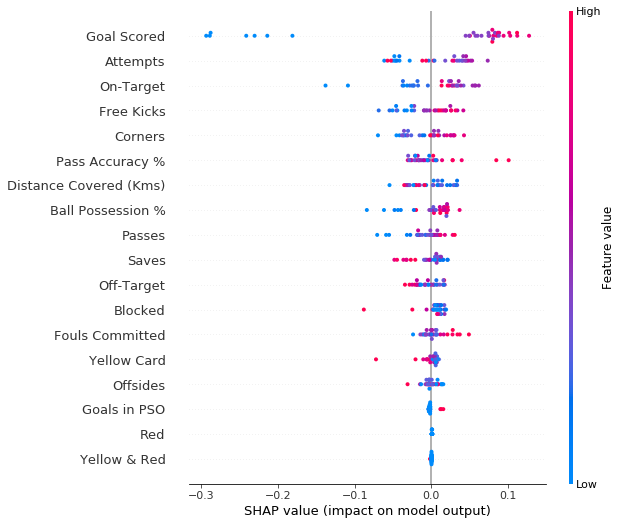

In [5]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

The code isn't too complex. But there are a few caveats.

- When plotting, we call `shap_values[1]`.  For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
- Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small.  But you'll want to be careful when running these to plot with reasonably sized datasets.  The exception is when using an `xgboost` model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

# SHAP Dependence Contribution Plots

We've previously used **Partial Dependence Plots** to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show.  For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

![Imgur](https://i.imgur.com/uQ2JmBm.png)

Start by focusing on the shape, and we'll come back to color in a minute.  Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction.  The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the *Man of the Match* award.

The spread suggests that other features must interact with Ball Possession %.  For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.

![Imgur](https://i.imgur.com/tFzp6jc.png)

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color. 

Consider the following very narrow example for concreteness.

![Imgur](https://i.imgur.com/NVB3eNW.png)

These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say **In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.**

Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.

# Dependence Contribution Plots in Code
We get the dependence contribution plot with the following code. The only line that's different from the `summary_plot` is the last line.

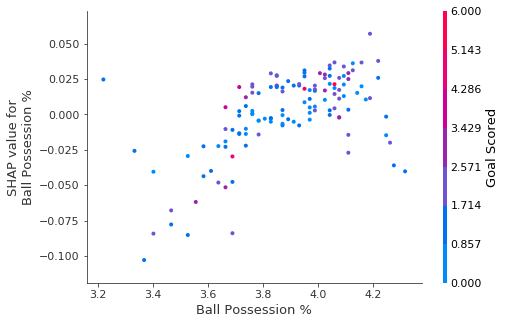

In [6]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

If you don't supply an argument for `interaction_index`, Shapley uses some logic to pick one that may be interesting.

This didn't require writing a lot of code. But the trick with these techniques is in thinking critically about the results rather than writing code itself.

# Exercise

## Set Up


We have again provided code to do the basic loading, review and model-building. Run the cell below to set everything up:

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# Environment Set-Up for feedback system.
#from learntools.core import binder
#binder.bind(globals())
#from learntools.ml_explainability.ex5 import *
#print("Setup Complete")


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/hospital-readmissions.csv')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Some versions of shap package error when mixing bools and numerics
X = data[base_features].astype(float)
X['num_medications'] = np.log(X['num_medications'])

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

In [11]:
X.head()

,number_inpatient,num_medications,number_diagnoses,num_lab_procedures,num_procedures,time_in_hospital,number_outpatient,number_emergency,gender_Female,payer_code_?,medical_specialty_?,diag_1_428,diag_1_414,diabetesMed_Yes,A1Cresult_None
0,0.0,2.397895,6.0,41.0,0.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,1.0,2.484907,9.0,30.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,2.0,3.091042,9.0,66.0,0.0,5.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,2.079442,8.0,63.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,1.0,1.791759,9.0,40.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [8]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


The first few questions require examining the **distribution of effects for each feature**, rather than just an average effect for each feature.  Run the following cell for a summary plot of the shap_values for readmission. It will take about 20 seconds to run.

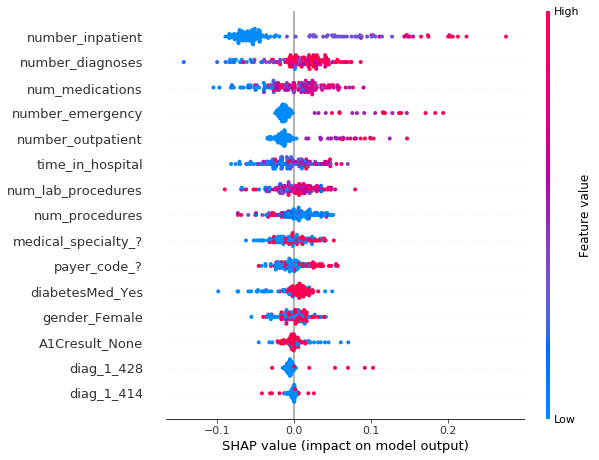

In [12]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)

shap.summary_plot(shap_values[1], small_val_X)

## Question 1

Which of the following features has a bigger range of effects on predictions (i.e. larger difference between most positive and most negative effect)
- `diag_1_428` or
- `payer_code_?`

In [6]:
# set following variable to 'diag_1_428' or 'payer_code_?'
feature_with_bigger_range_of_effects = 'diag_1_428'

Solution:

The range of diag_1_428 is wider, largely due to the few points on the far right.   
```feature_with_bigger_range_of_effects = 'diag_1_428'```

## Question 2

Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not?  

If the **range of effect sizes** measures something different from **permutation importance**: which is a better answer for the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?"

Run the following line after you've decided your answer.

My Answer: I don't think the range of effect sizes is a good indicator, because this feature can impact the model a lot but the interesting difining value (E.g. When feat_1 = False) may only happen in 2% of the cases. While it is important, it is very insignificant in the overall model prediction capability.
The **permutation importance** is simpler and answers the question of which two features is more important to understand the target. 

Solution: No. The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

## Question 3

Both `diag_1_428` and `payer_code_?` are binary variables, taking values of 0 or 1.

From the graph, which do you think would typically have a bigger impact on predicted readmission risk:
- Changing `diag_1_428` from 0 to 1
- Changing `payer_code_?` from 0 to 1

To save you scrolling, we have included a cell below to plot the graph again (this one runs quickly).

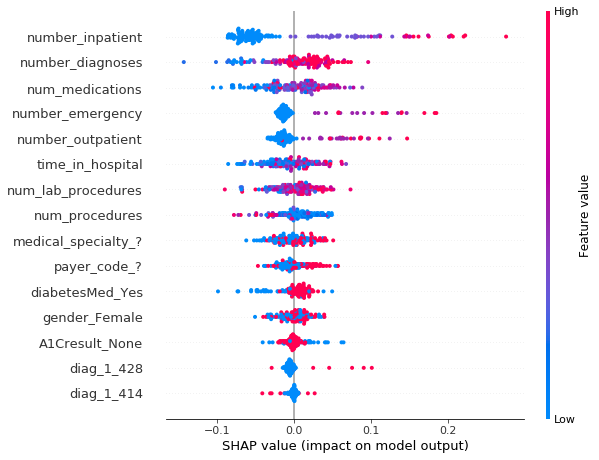

In [7]:
shap.summary_plot(shap_values[1], small_val_X)

In [8]:
# Set following var to "diag_1_428" if changing it to 1 has bigger effect.  Else set it to 'payer_code_?'
bigger_effect_when_changed = "diag_1_428"

Solution: While most SHAP values of diag_1_428 are small, the few pink dots (high values of the variable, corresponding to people with that diagnosis) have large SHAP values. In other words, the pink dots for this variable are far from 0, and making someone have the higher (pink) value would increase their readmission risk significantly. In real-world terms, this diagnosis is rare, but poses a larger risk for people who have it. In contrast, payer_code_? has many values of both blue and pink, and both have SHAP values that differ meaningfully from 0. But changing payer_code_? from 0 (blue) to 1 (pink) is likely to have a smaller impact than changing diag_1_428.


## Question 4

Some features (like `number_inpatient`) have reasonably clear separation between the blue and pink dots. Other variables like `num_lab_procedures` have blue and pink dots jumbled together, even though the SHAP values (or impacts on prediction) aren't all 0.

What do you think you learn from the fact that `num_lab_procedures` has blue and pink dots jumbled together? Once you have your answer, run the line below to verify your solution.

My Answer: I think it's because it has little importance in the model overall that it's high values are dictated by it's interaction with other features and not based on the feature itself.

Solution: The jumbling suggests that sometimes increasing that feature leads to higher predictions, and other times it leads to a lower prediction. Said another way, both high and low values of the feature can have both positive and negative effects on the prediction. The most likely explanation for this "jumbling" of effects is that the variable (in this case num_lab_procedures) has an interaction effect with other variables. For example, there may be some diagnoses for which it is good to have many lab procedures, and other diagnoses where suggests increased risk.  
**We don't yet know what other feature is interacting with num_lab_procedures though we could investigate that with SHAP contribution dependence plots.**

## Question 5

Consider the following SHAP contribution dependence plot. 

The x-axis shows `feature_of_interest` and the points are colored based on `other_feature`.

![Imgur](https://i.imgur.com/zFdHneM.png)

Is there an interaction between `feature_of_interest` and `other_feature`?  
If so, does `feature_of_interest` have a more positive impact on predictions when `other_feature` is high or when `other_feature` is low?


There is an inversally proportional interaction between the two features.   
The lower is the `feature_of_interest` the higher is it's SHAP value 

Run the following code when you are ready for the answer.

Solution: First, recall that the SHAP value is an estimate of the impact of a given feature on the prediction. So, if the dots trend from upper left to lower right, that means low values of feature_of_interest cause higher predictions.

Returning to this graph:

feature_of_interest slopes downward for high values of other_feature. To see this, focus your eye on the pink dots (where other_feature is high) and imagine a best-fit line through those pink dots. It slopes down, suggesting that the prediction goes down as feature_of_interest increases.

Now focus your eye on the blue dots, and imagine a best fit line through those dots. It is generally pretty flat, possibly even curving up on the right side of the graph. So increasing feature_of_interest has a **more positive impact** on predictions when other_feature is high.


## Question 6

Review the summary plot for the readmission data by running the following cell:

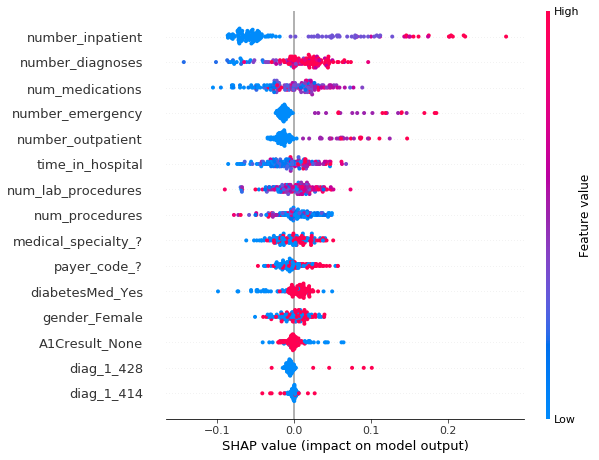

In [9]:
shap.summary_plot(shap_values[1], small_val_X)

Both **num_medications** and **num_lab_procedures** share that jumbling of pink and blue dots.

Aside from `num_medications` having effects of greater magnitude (both more positive and more negative), it's hard to see a meaningful difference between how these two features affect readmission risk.  Create the SHAP dependence contribution plots for each variable, and describe what you think is different between how these two variables affect predictions.

As a reminder, here is the code you previously saw to create this type of plot.

    shap.dependence_plot(feature_of_interest, shap_values[1], val_X)
    
And recall that your validation data is called `small_val_X`.

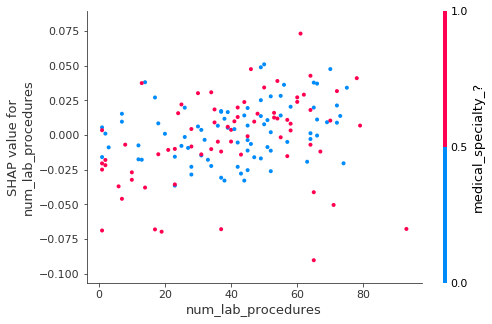

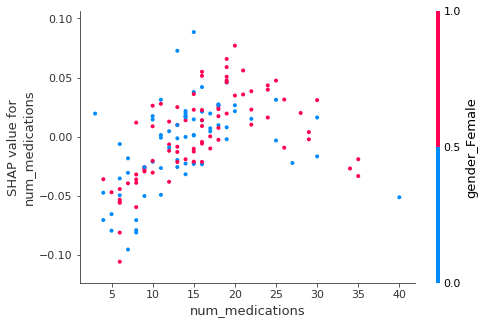

In [10]:
shap.dependence_plot('num_lab_procedures', shap_values[1], small_val_X)
shap.dependence_plot('num_medications', shap_values[1], small_val_X)

Loosely speaking, `num_lab_procedures` looks like a cloud with little disernible pattern. It does not slope steeply up nor down at any point. It's hard to say we've learned much from that plot. At the same time, the values are not all very close to 0. So the model seems to think this is a relevant feature. One potential next step would be to explore more by coloring it with different other features to search for an interaction.

On the other hand, `num_medications` clearly slopes up until a value of about 20, and then it turns back down. Without more medical background, this seems a surprising phenomenon... You could do some exploration to see whether these patients have unusual values for other features too. But a good next step would be to discuss this phenomenon with domain experts (in this case, the doctors).

# Congratulations

That's it!  Machine learning models should not feel like black boxes any more, because you have the tools to inspect them and understand what they learn about the world. 

This is an excellent skill for debugging models, building trust, and learning insights to make better decisions. These techniques have revolutionized how I do data science, and I hope they do the same for you.

Real data science involves an element of exploration. I hope you find an interesting dataset to try these techniques on (Kaggle has a lot of [free datasets](https://www.kaggle.com/datasets) to try out). If you learn something interesting about the world, share your work [in this forum](https://www.kaggle.com/learn-forum/66354). I'm excited to see what you do with your new skills.